**Table of contents**<a id='toc0_'></a>    
- [When the Customer Is Right: Analyzing Automotive Customer Complaint Data to Identify Serious Safety Issues](#toc1_)    
  - [Step 1](#toc1_1_)    
    - [Identify Components Most Implicated in Recalls](#toc1_1_1_)    
      - [Recalls EDA](#toc1_1_1_1_)    
      - [Filter for Manufacturers of Interest](#toc1_1_1_2_)    
      - [Split Components](#toc1_1_1_3_)    
  - [Step 2](#toc1_2_)    
    - [Load and Clean Complaints Data](#toc1_2_1_)    
      - [Complaints EDA](#toc1_2_1_1_)    
      - [Extract Select Complaints Data](#toc1_2_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [421]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np

In [422]:
def remove_punct(df):
    """
    Removes semantically meaningless punctuation (components use : to denote hierarchy)
    Parameters:
        df (dataframe): dataframe containing text for cleaning
    Returns:
        dataframe
    """
    cols = df.columns
    for col in cols:
        try:
            if df[col].dtype == "O" and col != "COMPNAME" and col != "COMPDESC":
                df.loc[:, col] = df[col].str.replace(r"[^\w\s-]", "", regex=True)
        except AttributeError as e:
            print(f"Check for non-string datatypes in {col}: {e}")


def lowercase(df):
    """
    Converts text to lowercase.
    Parameters:
        df (dataframe): dataframe containing text for cleaning
    Returns:
        dataframe
    """
    cols = df.columns
    for col in cols:
        try:
            if df[col].dtype == "O":
                df.loc[:, col] = df[col].str.lower()
        except AttributeError as e:
            print(f"Check for non-string datatypes: {e}")


def convert_datetime(data, columns=None, format="%Y%m%d", errors="coerce"):
    """
    Converts given columns to datetime.
    Parameters:
        data (pandas.DataFrame): The DataFrame containing the data to be converted.
        columns (list | None): The list of column names to be converted to datetime (default is ["RCDATE", "DATEA"]).
        format (str, optional): The format string used to parse the datetime columns (default is "%Y%m%d").
        errors (str, optional): How to handle parsing errors. Options are "raise", "coerce",
          and "ignore" (default is "coerce", which converts parsing errors to NaT).

    Returns:
        None: The function modifies the input DataFrame in place
    """
    if columns is None:
        columns = ["RCDATE", "DATEA", "ODATE", "BGMAN", "ENDMAN"]
    for col in columns:
        data[col] = pd.to_datetime(data[col].astype(str), format=format, errors=errors)

# <a id='toc1_'></a>[When the Customer Is Right: Analyzing Automotive Customer Complaint Data to Identify Serious Safety Issues](#toc0_)

## <a id='toc1_1_'></a>[Step 1](#toc0_)
### <a id='toc1_1_1_'></a>[Identify Components Most Implicated in Recalls](#toc0_)

In [423]:
# Load recall data
recalls_headers = pd.read_csv("./data/RCL_headers.txt")
recalls_head = recalls_headers.values.tolist()
rcl_headers = [head for sublist in recalls_head for head in sublist]

recalls = pd.read_csv(
    "./data/FLAT_RCL.txt", sep="\t", names=rcl_headers, on_bad_lines="warn"
)

Skipping line 188394: expected 27 fields, saw 34

/var/folders/4x/y38ttwq12519_qtj737r25vh0000gn/T/ipykernel_1357/2183926908.py:6: DtypeWarning: Columns (17,18,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  recalls = pd.read_csv(


In [424]:
# Examine mixed dtypes for potential problems
recalls.iloc[:, [17,18,24,25,26]].sample(10)


,RPNO,FMVSS,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO
60688,571.0,108.0,NaN,NaN,NaN
246997,NaN,NaN,HOUSING_REAR VIEW MIRROR LH ASSY,Mirror Housing Assembly - Left side,705015049
75218,NaN,NaN,NaN,NaN,NaN
73814,NaN,NaN,NaN,NaN,NaN
178613,NaN,NaN,SW HERMES,Control Module Unit Software,A2139027520
20718,571.0,301.0,NaN,NaN,NaN
243529,NaN,NaN,NUT,M6X1.0 HX WSHR CON NYL CL8 R102C,"SC00007247-A, SC00007247-B"
169915,NaN,NaN,SW HERMES,Control Module Unit Software,A2479029901
247611,NaN,NaN,Single ABS Modulator Valve,Quick Release Pneumatic Valve,"WAB472 196 037 0, WAB472 196 025 0"
78292,NaN,NaN,NaN,NaN,NaN


In [425]:
recalls.sample(2)

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,RPNO,FMVSS,DESC_DEFECT,CONEQUENCE_DEFECT,CORRECTIVE_ACTION,NOTES,RCL_CMPT_ID,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO
36757,36758,05V026000,ORION,VI,1998,04C-2,ENGINE AND ENGINE COOLING:ENGINE:OTHER FUEL TY...,ORION BUS INDUSTRIES LTD.,19980701.0,19991231.0,...,NaN,NaN,ON CERTAIN TRANSIT BUSES EQUIPPED WITH DETROI...,"IN THE EVENT THE TURBOCHARGER FAILS, A FIRE M...",DETROIT DIESEL IS CONDUCTING THE OWNER NOTIFIC...,ORION & DETROIT DIESEL RECALL NO. 04C-2.CUSTOM...,000021738000204058000000133,NaN,NaN,NaN
3231,3232,01V339000,TRIUMPH,SPRINT ST,2001,NaN,POWER TRAIN:CLUTCH ASSEMBLY:PEDAL/HAND LEVER(M...,TRIUMPH MOTORCYCLES,20000801.0,20010630.0,...,NaN,NaN,VEHICLE DESCRIPTION: MOTORCYCLES. THE CLUTCH...,THIS CAUSES THE RIDER TO BE UNABLE TO ENGAGE T...,DEALERS WILL REPLACE THE CLUTCH CABLE. OWNER ...,ALSO CONTACT THE NATIONAL HIGHWAY TRAFFIC SAFE...,000014584000092929000000173,NaN,NaN,NaN


In [426]:
recalls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248841 entries, 0 to 248840
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   RECORD_ID          248841 non-null  int64  
 1   CAMPNO             248841 non-null  object 
 2   MAKETXT            248841 non-null  object 
 3   MODELTXT           248841 non-null  object 
 4   YEARTXT            248841 non-null  int64  
 5   MFGCAMPNO          150692 non-null  object 
 6   COMPNAME           248841 non-null  object 
 7   MFGNAME            248836 non-null  object 
 8   BGMAN              115289 non-null  float64
 9   ENDMAN             115533 non-null  float64
 10  RCLTYPECD          248841 non-null  object 
 11  POTAFF             248555 non-null  float64
 12  ODATE              236645 non-null  float64
 13  INFLUENCED_BY      248841 non-null  object 
 14  MFGTXT             248841 non-null  object 
 15  RCDATE             248841 non-null  int64  
 16  DA

In [427]:
# Basic data cleaning
lowercase(recalls)
remove_punct(recalls)
convert_datetime(recalls)
convert_datetime(recalls, columns=["YEARTXT"], format="%Y")
recalls.sample(10)

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,RPNO,FMVSS,DESC_DEFECT,CONEQUENCE_DEFECT,CORRECTIVE_ACTION,NOTES,RCL_CMPT_ID,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO
111731,111732,15v522000,mack,granite gu,2016-01-01,sc0393,"service brakes, air:supply:hoses, lines/piping...",mack trucks inc,NaT,NaT,...,NaN,NaN,mack trucks inc mack is recalling certain mode...,if the electrical cables and air lines were to...,mack will notify owners and dealers will inspe...,owners may also contact the national highway t...,000057951001991843000000097,NaN,NaN,NaN
173221,173222,21v058000,mercedes-maybach,s650,2020-01-01,2021020025,electrical system:software,mercedes-benz usa llc,NaT,NaT,...,NaN,NaN,mercedes-benz usa llc mbusa is recalling certa...,failure of the ecall system may result in emer...,mbusa will notify owners and the communication...,owners may also contact the national highway t...,000108471004701757000001105,sw hermes,control module unit software,a2479026702
189480,189484,22v501000,toyota,tundra,2022-01-01,22ta07,electrical system:adas:parking assist:software,toyota motor engineering manufacturing,NaT,NaT,...,NaN,NaN,toyota motor engineering manufacturing toyota...,a rearview camera that fails to display the co...,dealers will reprogram the parking assist ecu ...,owners may also contact the national highway t...,000122028005042749000001766,parking assist ecu,computer parking assist,86792-0c051
120208,120209,16v532000,tiffin,allegro,2010-01-01,tiff-100,visibility:windshield wiper/washer,tiffin motorhomes inc,NaT,NaT,...,NaN,NaN,tiffin motorhomes inc tiffin is recalling cert...,if the windshield wiper arms break the drivers...,tiffin will notify owners and dealers will rep...,owners may also contact the national highway t...,000059211000878917000000243,NaN,NaN,NaN
246012,246016,23v178000,mercedes-benz,amg gle53,2023-01-01,2023040011,structure:body,mercedes-benz usa llc,NaT,NaT,...,NaN,NaN,mercedes-benz usa llc mbusa is recalling certa...,detached trim bars may cause a road hazard and...,dealers will inspect and secure the rear windo...,owners may also contact the national highway t...,000124931005546942000000275,side window pane,side window pane,a1677301208
50304,50305,06v283000,ic,cesb,2006-01-01,06507,seats,international truck engine corporation,NaT,NaT,...,NaN,NaN,certain my 2006 and 2007 ic ce and 2007 be sch...,in the event of a vehicle crash the mounting b...,ic corporation will notify owners and repair t...,international recall no 06507customers may con...,000022874000207776000000318,NaN,NaN,NaN
198120,198124,21v081000,ford,mustang,2011-01-01,21s05,air bags:frontal,ford motor company,NaT,NaT,...,NaN,NaN,ford motor company ford is recalling certain 2...,in the event of a crash necessitating deployme...,ford will notify owners and dealers will inspe...,owners may also contact the national highway t...,000108668000975775000000257,passenger airbag,2007-2011 ranger,7l5z-10044a74-ab
163975,163976,21v058000,mercedes-benz,s550e,2017-01-01,2021020025,communication: auto crash notification,mercedes-benz usa llc,NaT,NaT,...,NaN,NaN,mercedes-benz usa llc mbusa is recalling certa...,failure of the ecall system may result in emer...,mbusa will notify owners and the communication...,owners may also contact the national highway t...,000108471003001717000001420,sw hermes,control module unit software,a2479026400
166813,166814,21v058000,mercedes-benz,cla250,2018-01-01,2021020025,communication: auto crash notification,mercedes-benz usa llc,NaT,NaT,...,NaN,NaN,mercedes-benz usa llc mbusa is recalling certa...,failure of the ecall system may result in emer...,mbusa will notify owners and the communication...,owners may also contact the national highway t...,000108471002893717000001420,sw hermes,control module unit software,a2479026400
25414,25415,91v111000,prevost,astral xl,1987-01-01,NaN,electrical system:wiring,prevost car incorporated,NaT,NaT,...,NaN,NaN,inappropriate installation tightening of the t...,Na

In [428]:
recalls["ODATE"]

0        NaT
1        NaT
2        NaT
3        NaT
4        NaT
          ..
248836   NaT
248837   NaT
248838   NaT
248839   NaT
248840   NaT
Name: ODATE, Length: 248841, dtype: datetime64[ns]

#### <a id='toc1_1_1_1_'></a>[Recalls EDA](#toc0_)

In [429]:
# Number of recall campaigns
print(f"Recall campaigns count: {len(recalls['CAMPNO'].unique())}")

# Number of unique components recalled
print(f"Number of unique components recalled: {len(recalls['RCL_CMPT_ID'].unique())}")

# Timeframe of Complaints
print(f"Earliest recall report: {min(recalls['RCDATE'])}\n Most recent recall report: {max(recalls['RCDATE'])}")

Recall campaigns count: 27436
Number of unique components recalled: 176081
Earliest recall report: 1966-01-19 00:00:00
 Most recent recall report: 2023-11-10 00:00:00


In [430]:
# Check for variations in manufacturer name for companies of interest
# GM, Toyota, Tesla, Ford, Hyundai, Honda
gm = recalls.query('MFGNAME.str.contains("general motors", case=False, na=False)')
gm.loc[gm["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['general motors corp', 'general motors llc']

In [431]:
toyota = recalls.query('MFGNAME.str.contains("toyota", case=False, na=False)')
toyota.loc[toyota["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['toyota motor north america inc',
 'southeast toyota distributors',
 'gulf states toyota inc',
 'toyota motor co ltd',
 'toyota motor engineering  manufacturing',
 'southeast toyota distributors llc']

In [432]:
tesla = recalls.query('MFGNAME.str.contains("tesla", case=False, na=False)')
tesla.loc[tesla["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['tesla motors inc', 'tesla motors', 'tesla inc']

In [433]:
ford = recalls.query('MFGNAME.str.contains("ford", case=False, na=False)')
ford.loc[ford["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['ford motor company',
 'ford mtr co-overseas',
 'zf lemforder corporation',
 'ford motor company test adw as',
 'c  c ford']

In [434]:
hyundai = recalls.query('MFGNAME.str.contains("hyundai", case=False, na=False)')
hyundai.loc[hyundai["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['hyundai motor company',
 'hyundai caribbean-puerto rico',
 'hyundai translead',
 'hyundai motor america',
 'hyundai truck america']

In [435]:
honda = recalls.query('MFGNAME.str.contains("honda", case=False, na=False)')
honda.loc[honda["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['american honda motor co', 'honda american honda motor co', 'honda of minola']

In [436]:
# Standardize manufacturer names
recalls["MFGNAME"].replace(
    {
        "general motors llc": "general motors corp",
        "tesla motors inc": "tesla inc",
        "tesla motors": "tesla inc",
        "honda american honda motor co": "american honda motor co",
    },
    inplace=True,
)

In [437]:
# Check standardization
honda = recalls.query('MFGNAME.str.contains("honda", case=False, na=False)')
honda.loc[honda["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['american honda motor co', 'honda of minola']

In [438]:
recalls_mfr_count = pd.DataFrame(recalls["MFGNAME"].value_counts(ascending=False))

print(
    f"Top 20 manufacturers most represented in recall data:\n{recalls_mfr_count[:20]}"
)

Top 20 manufacturers most represented in recall data:
                                         count
MFGNAME                                       
mercedes-benz usa llc                    41784
ford motor company                       12779
general motors corp                      10062
american honda motor co                   7044
daimler trucks north america llc          6932
paccar incorporated                       4920
forest river inc                          4637
nissan north america inc                  3593
bmw of north america llc                  3550
toyota motor engineering  manufacturing   3181
volkswagen group of america inc           3156
jaguar land rover north america llc       3015
chrysler corporation                      2804
chrysler fca us llc                       2670
blue bird body company                    2619
winnebago industries inc                  2306
navistar inc                              2276
prevost car us inc                        2270
daimle

In [439]:
recalls_mfr_count["percentage_of_recalls"] = recalls_mfr_count["count"] / len(recalls)
recalls_mfr_count.sort_values(by="percentage_of_recalls", ascending=False)[:20]

,count,percentage_of_recalls
MFGNAME,,
mercedes-benz usa llc,41784,0.167914
ford motor company,12779,0.051354
general motors corp,10062,0.040435
american honda motor co,7044,0.028307
daimler trucks north america llc,6932,0.027857
paccar incorporated,4920,0.019772
forest river inc,4637,0.018634
nissan north america inc,3593,0.014439
bmw of north america llc,3550,0.014266


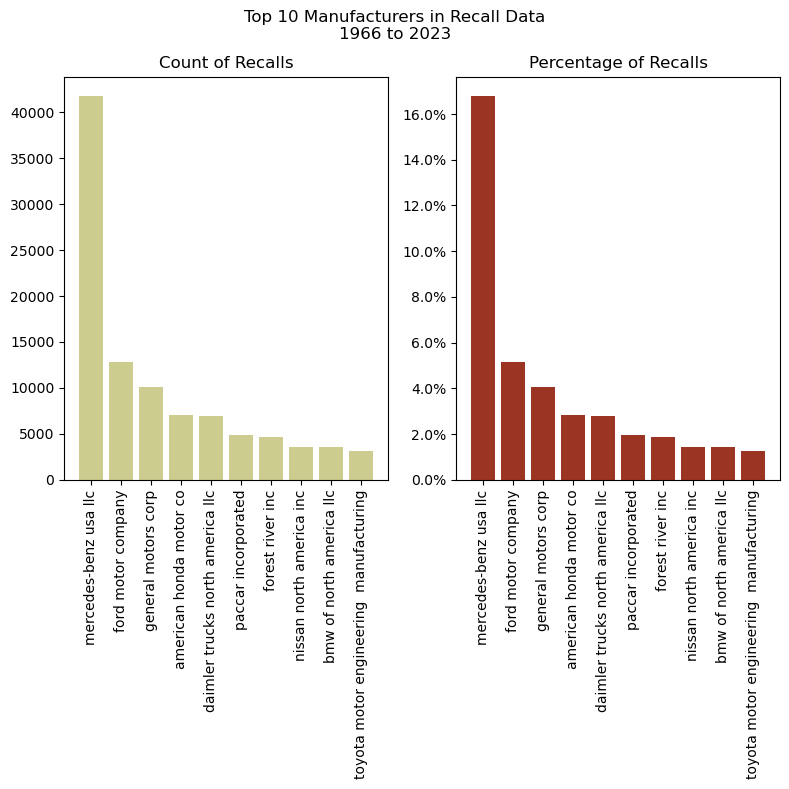

In [440]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
ax1.bar(
    recalls_mfr_count.reset_index()["MFGNAME"][:10],
    recalls_mfr_count["count"][:10],
    color="#cbcc8d",
)
ax1.set_xticks(recalls_mfr_count.reset_index()["MFGNAME"][:10])
ax1.set_xticklabels(recalls_mfr_count.reset_index()["MFGNAME"][:10], rotation=90)
ax1.set_title("Count of Recalls")

ax2.bar(
    recalls_mfr_count.reset_index()["MFGNAME"][:10],
    recalls_mfr_count["percentage_of_recalls"][:10],
    color="#9c3424",
)
ax2.set_xticks(recalls_mfr_count.reset_index()["MFGNAME"][:10])
ax2.set_xticklabels(recalls_mfr_count.reset_index()["MFGNAME"][:10], rotation=90)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.set_title("Percentage of Recalls")
plt.suptitle("Top 10 Manufacturers in Recall Data\n1966 to 2023")
plt.tight_layout()

In [441]:
# Get list of recall-prone components
rcl_common_compnames = pd.DataFrame(
    recalls["COMPNAME"].value_counts(ascending=False)[:50]
).reset_index()
rcl_common_compnames.to_csv("./output/allrcl_common_comps.csv")
rcl_common_compnames

,COMPNAME,count
0,electrical system:software,18922
1,communication: auto crash notification,16630
2,equipment,11825
3,equipment:recreational vehicle/trailer,8015
4,equipment adaptive/mobility,5201
5,exterior lighting,4945
6,equipment:other:labels,4927
7,air bags:frontal:passenger side:inflator module,4440
8,electrical system,4364
9,"fuel system, gasoline:delivery:fuel pump",4111


#### <a id='toc1_1_1_2_'></a>[Filter for Manufacturers of Interest](#toc0_)

In [442]:
select_mfrs = [
    "general motors corp",
    "tesla inc",
    "toyota motor north america inc",
    "ford motor company",
    "american honda motor co",
    "hyundai motor america",
]
recalls_filtered = recalls[recalls["MFGNAME"].isin(select_mfrs)]
recalls_filtered["MFGNAME"].value_counts()

MFGNAME
ford motor company                12779
general motors corp               10062
american honda motor co            7044
hyundai motor america               952
tesla inc                           607
toyota motor north america inc      477
Name: count, dtype: int64

#### <a id='toc1_1_1_3_'></a>[Split Components](#toc0_)

In [443]:
parts = recalls_filtered["COMPNAME"].str.split(":", expand=True)
parts.columns = [f"COMPSYS_{i + 1}" for i in range(len(parts.columns))]
parts

,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
0,electrical system,12v/24v/48v battery,cables,None,None
1,electrical system,12v/24v/48v battery,cables,None,None
48,wheels,None,None,None,None
49,wheels,None,None,None,None
148,"fuel system, other",storage,tank assembly,None,None
...,...,...,...,...,...
248696,electrical system,None,None,None,None
248697,electrical system,None,None,None,None
248698,electrical system,None,None,None,None
248723,power train,driveline,driveshaft,None,None


In [444]:
rcls_filter_enrich = pd.concat([recalls_filtered, parts], axis=1)
rcls_filter_enrich.head()

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,NOTES,RCL_CMPT_ID,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
0,1,02v288000,ford,focus,2000-01-01,02s41,electrical system:12v/24v/48v battery:cables,ford motor company,NaT,NaT,...,also contact the national highway traffic safe...,000015339000215021000000202,NaN,NaN,NaN,electrical system,12v/24v/48v battery,cables,None,None
1,2,02v288000,ford,focus,2001-01-01,02s41,electrical system:12v/24v/48v battery:cables,ford motor company,NaT,NaT,...,also contact the national highway traffic safe...,000015339000215022000000202,NaN,NaN,NaN,electrical system,12v/24v/48v battery,cables,None,None
48,49,02v250000,honda,silver wing,2002-01-01,NaN,wheels,american honda motor co,NaT,NaT,...,also customers can contact the national highwa...,000015234000106389000000309,NaN,NaN,NaN,wheels,None,None,None,None
49,50,02v250000,honda,fsc600,2002-01-01,NaN,wheels,american honda motor co,NaT,NaT,...,also customers can contact the national highwa...,000015234000106390000000309,NaN,NaN,NaN,wheels,None,None,None,None
148,149,02v249000,ford,crown victoria,2002-01-01,02s39,"fuel system, other:storage:tank assembly",ford motor company,NaT,NaT,...,also contact the national highway traffic safe...,000015251000215009000000162,NaN,NaN,NaN,"fuel system, other",storage,tank assembly,None,None


## <a id='toc1_2_'></a>[Step 2](#toc0_)
### <a id='toc1_2_1_'></a>[Load and Clean Complaints Data](#toc0_)

In [445]:
complt_headers = pd.read_csv("./data/CMPL_headers.txt")
complt_head = complt_headers.values.tolist()
cmpl_headers = [head for sublist in complt_head for head in sublist]

cmpl = pd.read_csv("./data/FLAT_CMPL.txt", sep="\t", names=cmpl_headers, on_bad_lines="warn")

Skipping line 555891: expected 49 fields, saw 70

/var/folders/4x/y38ttwq12519_qtj737r25vh0000gn/T/ipykernel_1357/2997329469.py:5: DtypeWarning: Columns (15,16,18,27,28,29,30,32,33,34,35,38,39,40,41,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  cmpl = pd.read_csv("./data/FLAT_CMPL.txt", sep="\t", names=cmpl_headers, on_bad_lines="warn")


In [446]:
# NOTE: CMPLID appears to just be the row number (index)
cmpl.head(2)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
1,958241,"Volvo Car USA, LLC",VOLVO,760,1987.0,N,NaN,N,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,N,N
2,958130,Ford Motor Company,FORD,THUNDERBIRD,1992.0,N,19941222.0,N,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,N,N


In [447]:
# Examine mixed dtypes for potential problems
print(cmpl.iloc[:, [15,16,18,27,28,29,30,32,33,34,35,38,39,40,41,42,43,44]].dtypes)

cmpl.iloc[:, [15,16,18,27,28,29,30,32,33,34,35,38,39,40,41,42,43,44]].sample(5)

LDATE              object
MILES             float64
CDESCR             object
FUEL_SYS           object
FUEL_TYPE          object
TRANS_TYPE         object
VEH_SPEED         float64
TIRE_SIZE          object
LOC_OF_TIRE        object
TIRE_FAIL_TYPE     object
ORIG_EQUIP_YN      object
RESTRAINT_TYPE     object
DEALER_NAME        object
DEALER_TEL         object
DEALER_CITY        object
DEALER_STATE       object
DEALER_ZIP         object
PROD_TYPE          object
dtype: object


,LDATE,MILES,CDESCR,FUEL_SYS,FUEL_TYPE,TRANS_TYPE,VEH_SPEED,TIRE_SIZE,LOC_OF_TIRE,TIRE_FAIL_TYPE,ORIG_EQUIP_YN,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE
1211215,20150820,NaN,TL* THE CONTACT OWNS A 2005 DODGE RAM 1500. T...,FI,GS,AUTO,NaN,NaN,NaN,NaN,NaN,NaN,MARK DODGE,NaN,LAKE CHARLES,LA,70605,V
1045650,20140313,60000.0,THE EMERGENCY BRAKE NEVER WORKED LIKE IT SHOUL...,NaN,GS,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
1607565,20190930,125000.0,THE SENSOR IN THE PASSENGER SEAT FOR THE PASSE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
765920,20100223,34000.0,AUTOMATIC TRANSMISSION WENT OUT OF MY CHRYSLER...,NaN,NaN,AUTO,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
287546,20010411,NaN,WHILE SLOWING DOWN TO MAKE A TURN VEHICLE BEGA...,NaN,GS,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V


In [448]:
cmpl["LDATE"]

1          19950103
2          19950103
3          19950103
4          19950103
5          19950103
             ...   
1944091    20231123
1944092    20231123
1944093    20231123
1944094    20231123
1944095    20231123
Name: LDATE, Length: 1943098, dtype: object

In [449]:
# cmpl["LDATE"] = pd.to_datetime(cmpl["LDATE"], format="%Y%m%d", errors="coerce")

In [450]:
# cmpl["LDATE"]

In [451]:
# Convert to datetime
convert_datetime(cmpl, columns=["FAILDATE", "DATEA", "LDATE", "PURCH_DT", "MANUF_DT"])
cmpl["YEARTXT"] = pd.to_datetime(cmpl["YEARTXT"], format="%Y", errors="coerce")

In [452]:
cmpl["LDATE"]

1         1995-01-03
2         1995-01-03
3         1995-01-03
4         1995-01-03
5         1995-01-03
             ...    
1944091   2023-11-23
1944092   2023-11-23
1944093   2023-11-23
1944094   2023-11-23
1944095   2023-11-23
Name: LDATE, Length: 1943098, dtype: datetime64[ns]

In [453]:
cmpl["YEARTXT"]

1         1987-01-01
2         1992-01-01
3         1994-01-01
4         1987-01-01
5         1991-01-01
             ...    
1944091   2015-01-01
1944092   2014-01-01
1944093   2014-01-01
1944094   2011-01-01
1944095   2022-01-01
Name: YEARTXT, Length: 1943098, dtype: datetime64[ns]

In [454]:
# Basic data cleaning
lowercase(cmpl)
remove_punct(cmpl)
cmpl.sample(10)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
413826,10024629,nissan north america inc,nissan,axxess,1990-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
739287,10287125,general motors llc,chevrolet,malibu maxx,2005-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1819538,11469819,ford motor company,ford,c-max energi,2015-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
716220,10265437,chrysler fca us llc,jeep,liberty,2006-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
771624,10317819,toyota motor corporation,toyota,matrix,2009-01-01,y,NaT,n,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1420783,11042545,subaru of america inc,subaru,legacy,2010-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
579466,10155525,michelin tire corp,michelin,michelin,NaT,n,NaT,n,0,0,...,NaN,unknown,NaN,NaN,NaN,NaN,t,n,n,NaN
1370592,10972196,toyota motor corporation,toyota,prius,2005-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1686474,11350765,ford motor company,ford,f-250,2013-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1801527,11457005,hyundai motor america,hyundai,santa fe,2016-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n


In [455]:
# Remove irrelevant Dealership information
cmpl.drop(["DEALER_NAME", "DEALER_TEL", "DEALER_CITY", "DEALER_STATE", "DEALER_ZIP",], axis=1, inplace=True)
cmpl.columns

Index(['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH',
       'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE',
       'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE',
       'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN',
       'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
       'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE',
       'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE',
       'RESTRAINT_TYPE', 'PROD_TYPE', 'REPAIRED_YN', 'MEDICAL_ATTN',
       'VEHICLES_TOWED_YN'],
      dtype='object')

In [456]:
gm = cmpl.query('MFR_NAME.str.contains("general motors", case=False, na=False)')
gm.loc[gm["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['general motors llc']

In [457]:
toy = cmpl.query('MFR_NAME.str.contains("toyota", case=False, na=False)')
toy.loc[toy["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['toyota motor corporation', 'toyota motor engineering  manufacturing']

In [458]:
tesla = cmpl.query('MFR_NAME.str.contains("tesla", case=False, na=False)')
tesla.loc[tesla["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['tesla inc']

In [459]:
ford = cmpl.query('MFR_NAME.str.contains("ford", case=False, na=False)')
ford.loc[ford["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['ford motor company']

In [460]:
hyundai = cmpl.query('MFR_NAME.str.contains("hyundai", case=False, na=False)')
hyundai.loc[hyundai["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['hyundai motor america',
 'hyundai truck service',
 'hyundai caribbean-puerto rico',
 'hyundai translead']

In [461]:
honda = cmpl.query('MFR_NAME.str.contains("honda", case=False, na=False)')
honda.loc[honda["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['honda american honda motor co']

In [462]:
# Standardize MFR_NAME for select manufacturers
replace_map = {
    "general motors llc": "general motors corp",
    "honda american honda motor co": "american honda motor co",
    "toyota motor corporation": "toyota motor north america inc",
}

cmpl.loc[:, "MFR_NAME"] = cmpl["MFR_NAME"].replace(replace_map)
cmpl[cmpl["MFR_NAME"] == "american honda motor co"][:2]

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,LOC_OF_TIRE,TIRE_FAIL_TYPE,ORIG_EQUIP_YN,MANUF_DT,SEAT_TYPE,RESTRAINT_TYPE,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
25,958184,american honda motor co,honda,accord,1990-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
77,958120,american honda motor co,honda,civic,1994-01-01,y,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n


#### <a id='toc1_2_1_1_'></a>[Complaints EDA](#toc0_)

In [463]:
# Number of complaints
print(f"Complaints count: {len(cmpl)}")

# Number of unique components recalled
print(f"Number of unique components implicated: {len(cmpl['COMPDESC'].unique())}")

# Timeframe of Complaints
print(f"Earliest Complaint: {min(cmpl['LDATE'])}\n Most recent complaint: {max(cmpl['LDATE'])}")

Complaints count: 1943098
Number of unique components implicated: 727
Earliest Complaint: 1995-01-01 00:00:00
 Most recent complaint: 2023-11-23 00:00:00


In [464]:
cmpl_mfr_count = pd.DataFrame(cmpl["MFR_NAME"].value_counts(ascending=False))

print(
    f"Top 20 manufacturers most represented in complaints data:\n{cmpl_mfr_count[:20]}"
)

Top 20 manufacturers most represented in complaints data:
                                      count
MFR_NAME                                   
general motors corp                  404556
ford motor company                   376858
chrysler fca us llc                  353781
toyota motor north america inc       139809
american honda motor co              108234
nissan north america inc              95550
hyundai motor america                 58621
volkswagen group of america inc       55422
kia america inc                       45291
bmw of north america llc              39965
subaru of america inc                 29985
mercedes-benz usa llc                 27487
mazda motor corp                      25149
tesla inc                             14472
mitsubishi motors north america inc   13713
unknown manufacturer                  13060
volvo car usa llc                     11662
suzuki motor usa llc                   6524
goodyear tire  rubber company          5793
isuzu motors limit

#### <a id='toc1_2_1_2_'></a>[Extract Select Complaints Data](#toc0_)

In [465]:
select_mfrs = [
    "general motors corp",
    "tesla inc",
    "toyota motor north america inc",
    "ford motor company",
    "american honda motor co",
    "hyundai motor america",
]

cmpl_filtered = cmpl[cmpl["MFR_NAME"].isin(select_mfrs) == True]
cmpl_filtered.sample(5)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,LOC_OF_TIRE,TIRE_FAIL_TYPE,ORIG_EQUIP_YN,MANUF_DT,SEAT_TYPE,RESTRAINT_TYPE,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
61790,510405,ford motor company,ford,f-450 sd,1991-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
656969,10217576,hyundai motor america,hyundai,accent,2007-01-01,y,NaT,n,2,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
219991,865109,ford motor company,ford,mustang,1995-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
1046288,10572546,general motors corp,gmc,sierra,2013-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
1391399,11004800,american honda motor co,honda,civic hybrid,2007-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n


In [466]:
cmpl_parts = cmpl_filtered["COMPDESC"].str.split(":", expand=True)
cmpl_parts.columns = [f"COMPSYS_{i + 1}" for i in range(len(cmpl_parts.columns))]
cmpl_parts

,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
2,"fuel system, gasoline",delivery,None,None,None
6,power train,None,None,None,None
7,air bags,frontal,None,None,None
14,"fuel system, gasoline",storage,tank assembly,None,None
15,steering,hydraulic power assist system,None,None,None
...,...,...,...,...,...
1944088,engine,None,None,None,None
1944092,electrical system,None,None,None,None
1944093,seat belts,None,None,None,None
1944094,steering,None,None,None,None


In [467]:
cmpl_filtered_enrich = pd.concat([cmpl_filtered, cmpl_parts], axis=1)
cmpl_filtered_enrich.head(3)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,RESTRAINT_TYPE,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
2,958130,ford motor company,ford,thunderbird,1992-01-01,n,NaT,n,0,0,...,NaN,v,NaN,n,n,"fuel system, gasoline",delivery,None,None,None
6,958246,ford motor company,ford,aerostar,1990-01-01,n,NaT,n,0,0,...,NaN,v,NaN,n,n,power train,None,None,None,None
7,958248,hyundai motor america,hyundai,elantra,1994-01-01,n,NaT,n,0,0,...,NaN,v,NaN,n,n,air bags,frontal,None,None,None


In [468]:
cmpl_filtered_enrich.shape

(1102550, 48)

In [469]:
# Filter for recall-prone parts
# Selected easily identifiable and commonly recalled parts
select_parts = [
    "air bags",
    "seat belts",
    "service brakes",
    "fuel system, gasoline",
    "power train",
    "visibility",
    "electrical system",
    "vehicle speed control",
    "wheels",
    "engine",
    "suspension",
]

cmpl_select_parts = cmpl_filtered_enrich[cmpl_filtered_enrich["COMPSYS_1"].isin(select_parts) == True].copy(deep=True)

In [470]:
print(cmpl_select_parts.shape)
cmpl_select_parts["COMPSYS_1"].value_counts()

(599331, 48)


COMPSYS_1
electrical system        116080
power train              101529
air bags                  83082
engine                    65238
vehicle speed control     53195
suspension                46163
service brakes            39831
visibility                32801
fuel system, gasoline     27521
seat belts                21256
wheels                    12635
Name: count, dtype: int64

In [471]:
cmpl_select_parts.to_csv("./output/cmpl_select_parts.csv")

In [472]:
cmpl_compsys = pd.DataFrame(cmpl_select_parts["COMPSYS_1"].value_counts())
cmpl_compsys = cmpl_compsys.reset_index()
cmpl_compsys.rename(columns={"COMPSYS_1": "compsys", "count": "num_complaints"}, inplace=True)
cmpl_compsys.to_csv("./output/cmpl_select_compsys_summary.csv")

## Step 3

### Spike Detection

#### Plot Raw Component Complaint Counts by Month

In [473]:
cmpl_select_parts.columns

Index(['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH',
       'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE',
       'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE',
       'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN',
       'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
       'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE',
       'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE',
       'RESTRAINT_TYPE', 'PROD_TYPE', 'REPAIRED_YN', 'MEDICAL_ATTN',
       'VEHICLES_TOWED_YN', 'COMPSYS_1', 'COMPSYS_2', 'COMPSYS_3', 'COMPSYS_4',
       'COMPSYS_5'],
      dtype='object')

In [474]:
cmpl_select_parts["LDATE"]

2         1995-01-03
6         1995-01-03
7         1995-01-03
14        1995-01-03
17        1995-01-03
             ...    
1944082   2023-11-23
1944086   2023-11-23
1944088   2023-11-23
1944092   2023-11-23
1944093   2023-11-23
Name: LDATE, Length: 599331, dtype: datetime64[ns]

In [475]:
cmpl_select_parts.isna().sum().sum()

12202737

In [476]:
cmpl_select_parts.dropna(subset=["LDATE"], inplace=True)

In [477]:
cmpl_select_parts["LDATE"]

2         1995-01-03
6         1995-01-03
7         1995-01-03
14        1995-01-03
17        1995-01-03
             ...    
1944082   2023-11-23
1944086   2023-11-23
1944088   2023-11-23
1944092   2023-11-23
1944093   2023-11-23
Name: LDATE, Length: 599330, dtype: datetime64[ns]

In [478]:
monthly_counts = cmpl_select_parts.groupby([cmpl_select_parts["LDATE"].dt.to_period("M"), "COMPSYS_1"]).size().reset_index(name="count")

In [479]:
monthly_counts["LDATE"]

0       1995-01
1       1995-01
2       1995-01
3       1995-01
4       1995-01
         ...   
3408    2023-11
3409    2023-11
3410    2023-11
3411    2023-11
3412    2023-11
Name: LDATE, Length: 3413, dtype: period[M]

In [480]:
monthly_counts.sort_values(by="LDATE", inplace=True)
print(len(monthly_counts))
monthly_counts.sample(5)

3413


,LDATE,COMPSYS_1,count
2812,2019-05,"fuel system, gasoline",4
1830,2011-11,suspension,116
824,2002-08,suspension,142
1361,2007-07,visibility,74
742,2001-11,seat belts,53


In [481]:
monthly_counts.dtypes

LDATE        period[M]
COMPSYS_1       object
count            int64
dtype: object

In [482]:
monthly_counts.sample(5)

,LDATE,COMPSYS_1,count
528,1999-11,vehicle speed control,135
2583,2017-08,seat belts,63
1203,2006-02,"fuel system, gasoline",56
2581,2017-08,"fuel system, gasoline",5
1045,2004-09,air bags,172


In [483]:
monthly_counts.isna().sum()

LDATE        0
COMPSYS_1    0
count        0
dtype: int64

In [484]:
monthly_counts['LDATE'] = monthly_counts['LDATE'].dt.to_timestamp()

In [485]:
monthly_counts.dtypes

LDATE        datetime64[ns]
COMPSYS_1            object
count                 int64
dtype: object

In [486]:
monthly_counts.sample(5)

,LDATE,COMPSYS_1,count
2940,2020-05-01,air bags,237
2619,2017-11-01,vehicle speed control,120
2839,2019-07-01,vehicle speed control,206
168,1996-07-01,vehicle speed control,74
246,1997-04-01,power train,136


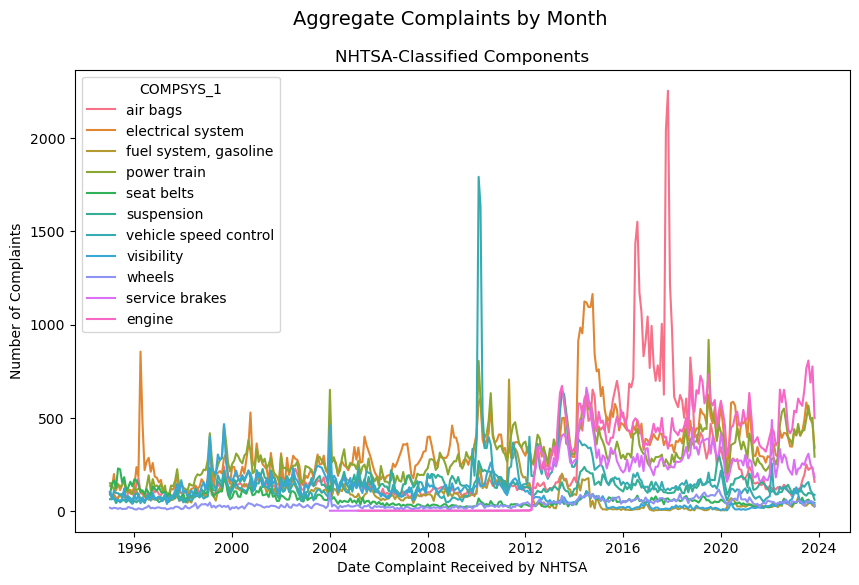

In [487]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='LDATE', y='count', data=monthly_counts, hue="COMPSYS_1")
plt.suptitle("Aggregate Complaints by Month", fontsize=14)
plt.title("NHTSA-Classified Components")
plt.xlabel("Date Complaint Received by NHTSA")
plt.ylabel("Number of Complaints")
plt.show()

In [488]:
cmpl_select_parts.columns

Index(['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH',
       'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE',
       'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE',
       'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN',
       'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
       'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE',
       'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE',
       'RESTRAINT_TYPE', 'PROD_TYPE', 'REPAIRED_YN', 'MEDICAL_ATTN',
       'VEHICLES_TOWED_YN', 'COMPSYS_1', 'COMPSYS_2', 'COMPSYS_3', 'COMPSYS_4',
       'COMPSYS_5'],
      dtype='object')

In [489]:
cmpl_select_parts["LDATE_month"] = cmpl_select_parts["LDATE"].dt.to_period("M").copy()

cmpl_m_mfr = cmpl_select_parts.groupby(['LDATE_month', 'MFR_NAME', 'COMPSYS_1']).size().reset_index(name='count')
cmpl_m_mfr['LDATE'] = cmpl_m_mfr['LDATE_month'].dt.to_timestamp()

In [490]:
cmpl_m_mfr["MFR_NAME"].unique()

array(['american honda motor co', 'ford motor company',
       'general motors corp', 'hyundai motor america',
       'toyota motor north america inc', 'tesla inc'], dtype=object)

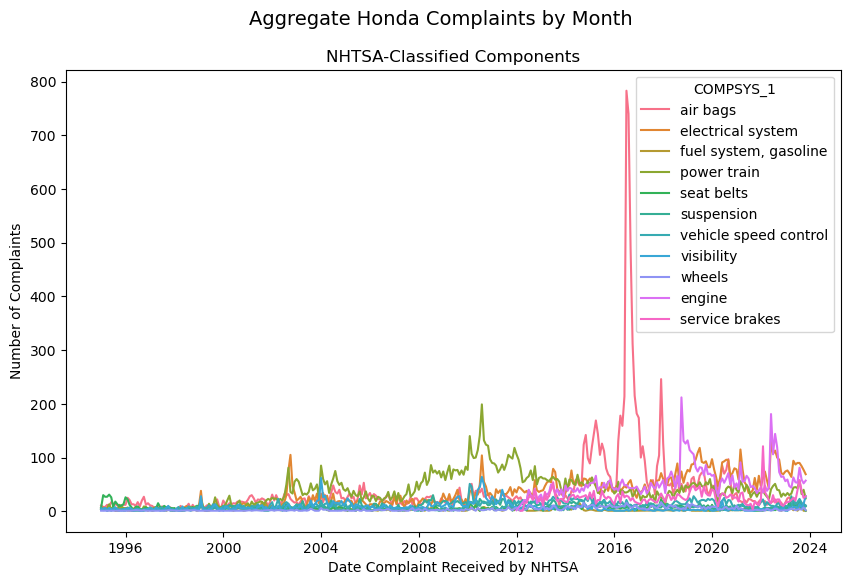

In [491]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='LDATE', y='count', data=cmpl_m_mfr[cmpl_m_mfr["MFR_NAME"] == "american honda motor co"], hue="COMPSYS_1")
plt.suptitle("Aggregate Honda Complaints by Month", fontsize=14)
plt.title("NHTSA-Classified Components")
plt.xlabel("Date Complaint Received by NHTSA")
plt.ylabel("Number of Complaints")
plt.show()

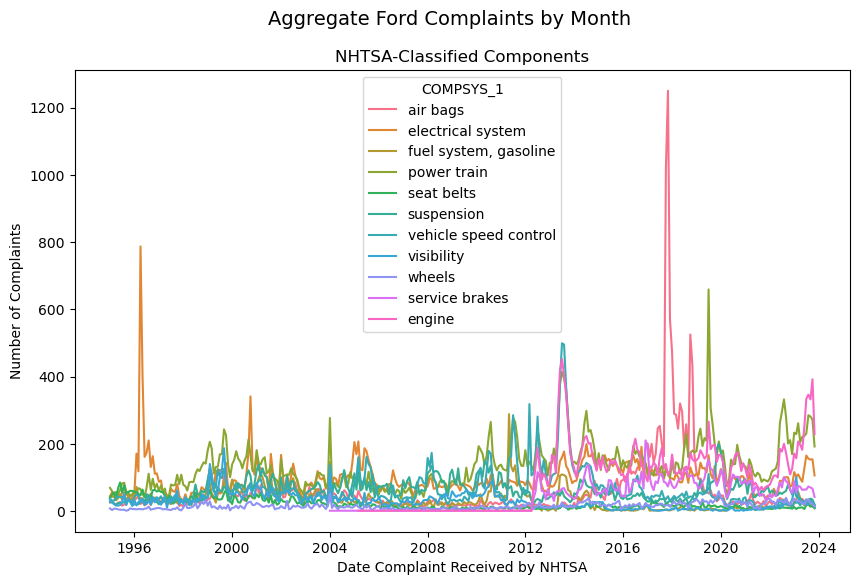

In [492]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='LDATE', y='count', data=cmpl_m_mfr[cmpl_m_mfr["MFR_NAME"] == "ford motor company"], hue="COMPSYS_1")
plt.suptitle("Aggregate Ford Complaints by Month", fontsize=14)
plt.title("NHTSA-Classified Components")
plt.xlabel("Date Complaint Received by NHTSA")
plt.ylabel("Number of Complaints")
plt.show()

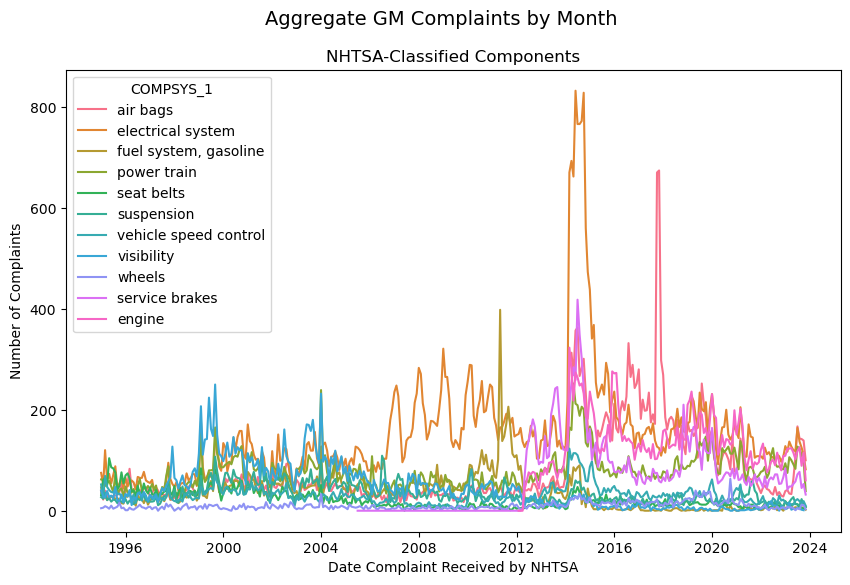

In [493]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='LDATE', y='count', data=cmpl_m_mfr[cmpl_m_mfr["MFR_NAME"] == "general motors corp"], hue="COMPSYS_1")
plt.suptitle("Aggregate GM Complaints by Month", fontsize=14)
plt.title("NHTSA-Classified Components")
plt.xlabel("Date Complaint Received by NHTSA")
plt.ylabel("Number of Complaints")
plt.show()

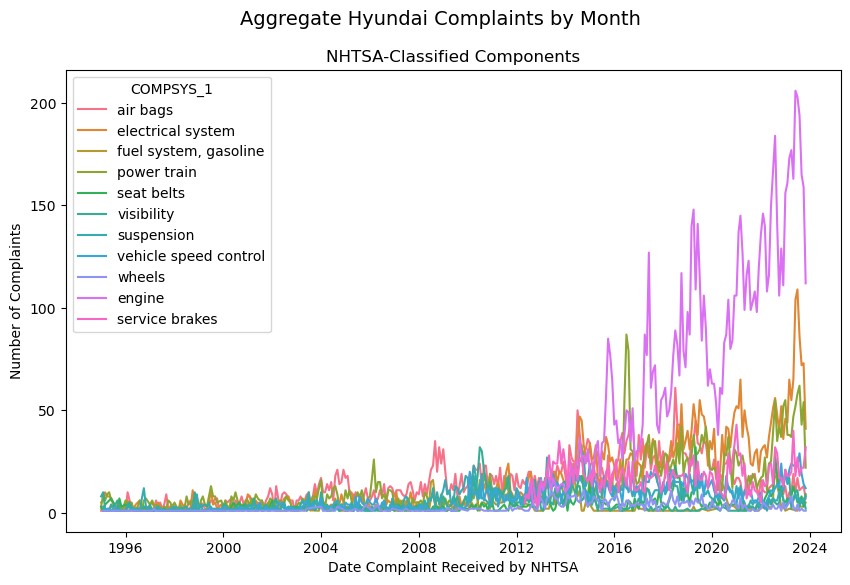

In [494]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='LDATE', y='count', data=cmpl_m_mfr[cmpl_m_mfr["MFR_NAME"] == "hyundai motor america"], hue="COMPSYS_1")
plt.suptitle("Aggregate Hyundai Complaints by Month", fontsize=14)
plt.title("NHTSA-Classified Components")
plt.xlabel("Date Complaint Received by NHTSA")
plt.ylabel("Number of Complaints")
plt.show()

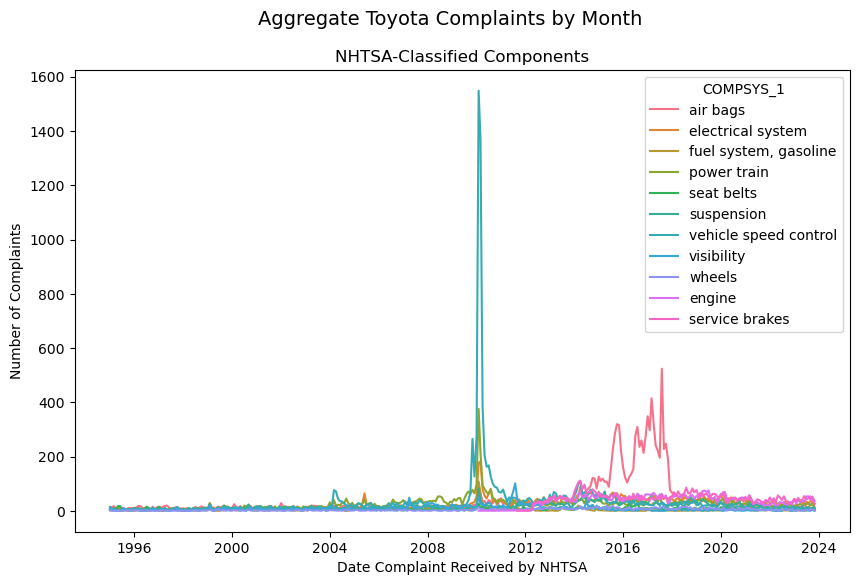

In [495]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='LDATE', y='count', data=cmpl_m_mfr[cmpl_m_mfr["MFR_NAME"] == "toyota motor north america inc"], hue="COMPSYS_1")
plt.suptitle("Aggregate Toyota Complaints by Month", fontsize=14)
plt.title("NHTSA-Classified Components")
plt.xlabel("Date Complaint Received by NHTSA")
plt.ylabel("Number of Complaints")
plt.show()

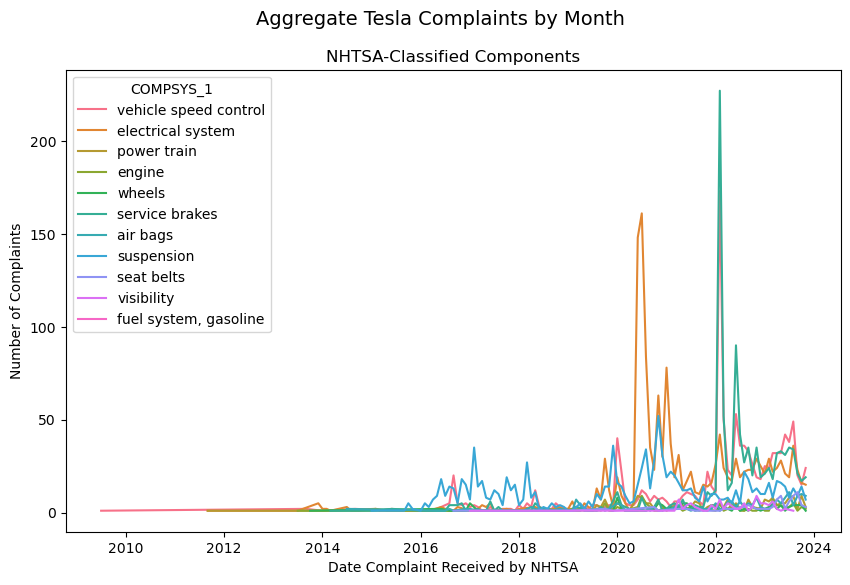

In [496]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='LDATE', y='count', data=cmpl_m_mfr[cmpl_m_mfr["MFR_NAME"] == "tesla inc"], hue="COMPSYS_1")
plt.suptitle("Aggregate Tesla Complaints by Month", fontsize=14)
plt.title("NHTSA-Classified Components")
plt.xlabel("Date Complaint Received by NHTSA")
plt.ylabel("Number of Complaints")
plt.show()

#### Spike Analysis

In [497]:
# STA/LTA on Hyundai engine complaints
hyun_engine = cmpl_m_mfr[(cmpl_m_mfr["MFR_NAME"] == "hyundai motor america") & (cmpl_m_mfr["COMPSYS_1"] == "engine")].copy()
hyun_engine.dtypes


LDATE_month         period[M]
MFR_NAME               object
COMPSYS_1              object
count                   int64
LDATE          datetime64[ns]
dtype: object

In [498]:
sta_lta = hyun_engine.drop(["LDATE_month", "MFR_NAME", "COMPSYS_1"], axis=1,)
sta_lta.dtypes

count             int64
LDATE    datetime64[ns]
dtype: object

In [499]:
# Average lifecycle of car is 5 years (60 months)
sta_lta['sta'] = sta_lta['count'].rolling(window=6, min_periods=1).mean()
sta_lta['lta'] = sta_lta['count'].rolling(window=60, min_periods=1).mean()
sta_lta['ratio'] = sta_lta['sta'] / sta_lta['lta']

In [500]:
sta_lta

,count,LDATE,sta,lta,ratio
8893,8,2012-05-01,8.000000,8.000000,1.000000
8947,8,2012-06-01,8.000000,8.000000,1.000000
9001,7,2012-07-01,7.666667,7.666667,1.000000
9055,15,2012-08-01,9.500000,9.500000,1.000000
9109,5,2012-09-01,8.600000,8.600000,1.000000
...,...,...,...,...,...
16705,203,2023-07-01,180.500000,113.350000,1.592413
16768,194,2023-08-01,186.000000,115.216667,1.614350
16833,165,2023-09-01,184.666667,116.850000,1.580374
16897,159,2023-10-01,181.666667,117.550000,1.545442


In [501]:
spikes = sta_lta[sta_lta["ratio"]>1.5].copy()
spikes.sort_values(by="LDATE")

,count,LDATE,sta,lta,ratio
10381,36,2014-08-01,23.333333,14.035714,1.662426
10436,27,2014-09-01,25.666667,14.482759,1.772222
10492,28,2014-10-01,26.333333,14.933333,1.763393
10549,24,2014-11-01,27.166667,15.225806,1.784251
10603,31,2014-12-01,28.500000,15.718750,1.813121
...,...,...,...,...,...
16642,206,2023-06-01,172.666667,111.450000,1.549275
16705,203,2023-07-01,180.500000,113.350000,1.592413
16768,194,2023-08-01,186.000000,115.216667,1.614350
16833,165,2023-09-01,184.666667,116.850000,1.580374
